In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(100)

import scipy as sp
from scipy.stats import t

import statsmodels.stats.diagnostic as smd # Диагностика моделей
import statsmodels.formula.api as smf # Модели
import statsmodels.stats.api as sms # Тесты
import statsmodels.stats.stattools as smst # ещё тесты

import unicodedata

# Предположения Гауссова-Маркова и свойства оценки наименьших квадратов


1. Модель корректна: все признаки, влияющие на Y учтены;
2. X детерминирована и колонки линейно независимы;
3. $\varepsilon_i$ независимы в совокупности и одинаково распределены, не зависят от наблюдений $X_i$, имеют нулевое матожидание и одинаковую дисперсию $σ$



> Тогда оценка наименьших квадратов в является несмещённой и эффективной в классе всех несмещённых оценок BLUE(Best Linear Unbiased Estimate)



## Задача 1: **F-test и логарифмирование**
Тестируем гипотезу,что $\beta_1+\beta_2 = 1$


Пример прологарифмированорованная функция выпуска Коба Дугласа, где
тестируем гипотезу что коэффициенты суммируются в единицу.

Функция выпуска Коба Дугласа— производственная функция (или функция полезности), отражающая зависимость объёма производства от создающих его факторов производства — затрат труда
$L$ и капитала $K$.

Данные: Капитал $K$ и Труд $L$

Модель: $Y =\gamma K^{\alpha} L^{\lambda} $

Хотим оценить $\alpha$ and $\gamma $
По идее чтобы построить линеую модель нужно взять логарифм от левой и правой части
Хотим проверить гипотезу, что функция производительности гомогенная, то есть Y  увеоичивается пропорционально увеличению K и L вместе:

Проверяем гипотезу: $\alpha+\lambda = 1$

## Решение Задача 1:

Сгенерим для удобства данные по формуле

In [ ]:
np.random.seed(100)
K = np.linspace(10,60,1000)+np.random.randint(-5, 5)
L = np.linspace(100,600,1000)+np.random.randint(-20, 20)
true_alpha = 0.4
true_gamma = 4
Y = true_gamma * K**(true_alpha)* L**(1-true_alpha)+np.random.randn(len(K))*0.1

Чтобы применить линейную регрессию для модели Кобба-Дугласа нужно взять логарифм от левой и правой части

$ln(Y) = ln(\gamma) + \alpha ln(K) +\lambda ln(L)$

В модели регрессии используем

Параметры
регресионной модели
$y = \beta_0 +\beta_1 x_1 +\beta_2 x_2$

Где, Таргет  $y = ln(Y)$, $x_1 = ln(K)$,$x_2 = ln(L)$


$ X = \begin{bmatrix}
1 & ln(K_1) & ln(L_1)\\
1 & ln(K_2) & ln(L_2) \\
⋯ &⋯  & ⋯ \\
1 & ln(K_n) & ln(L_n)
\end{bmatrix}$

Тогда $\beta_{UR} = (X^{T} X)^{-1} X^{T} y $

Теперь c  помощью F-test протестируем гипотезу, что $ \beta_1+\beta_2 = 1$

Построем регрессию с органичением, где $ \beta_2= 1-\beta_1 $
Тогда наша линейная регрессия с ограничениями будет выглядеть так:

$y = \beta_0 +\beta_1 x_1 +(1-\beta_1)x_2 $ то есть

$y - x_2 = \beta_0 +\beta_1 (x_1-x_2) $

Тогда новая формула для коэффициента линейной регрессии с ограничениями будет
$ X_R = \begin{bmatrix}
1 & ln(K_1) - ln(L_1)\\
1 & ln(K_2) - ln(L_2) \\
⋯ &⋯   \\
1 & ln(K_n) - ln(L_n)
\end{bmatrix}$ и
$\beta_{r} = (X_R^{T} X_R)^{-1} X_R^{T}(y -ln(L)) $

Посчитаем $F_{st}$ статистику, где
количество переменных $p = 2$,  количество ограничений $r = 1$  и количество наблюдений $n = 100$
$RSS_{R} = \| y-ln(L)- X_R\beta_{r} \|^{2}$
$$F_{st} = \frac{(\| y-ln(L)- X_R\beta_{r} \|^{2} - \| y - X \beta_{UR} \|^{2})/r}{\| y - X \beta_{UR}\|^{2}/(n - p)} =\frac{(RSS_{R} - RSS_{UR})/r}{ RSS_{UR}/(n-p)}  \sim F(r,n-p)$$

План
fit regression:

fit constrained regression:

calculate f-statitics and compare with general test from statmodels


In [ ]:
#Write your class of linear regression with t test and F-test:

class LinearRegression():
  def __init__(self, regularize = 0):
    self.regularize = 0

  def fit(self, X, y):
    '''
    X vector of shape(n_observations, n_features)
    y vector of shape  (n_observations, 1)
    returns beta of shape n_features
    '''
    self.n_observations = X.shape[0]
    self.n_features =  X.shape[1]
    assert X.shape[0] == len(y)

    self.X = X
    self.y = y
    beta  = np.linalg.inv(X.T@X)@X.T@y

    self.beta = beta

    return beta

  def RSS(self, X, y):
    return np.sum((y - X@self.beta)**2)

  def predict(self, X):
    return X@self.beta


  def standard_deviation_beta(self, kth_beta = 0):

      sigma_hat = self.RSS(self.X, self.y)/(self.n_observations - self.n_features)
      X_X_inv = np.linalg.inv(self.X.T@self.X)

      return np.sqrt(sigma_hat*X_X_inv[kth_beta, kth_beta])

In [ ]:
#unconstraineed regression:
lin_reg_uncostrained = LinearRegression()
X = np.stack([np.ones_like(K), np.log(K), np.log(L)]).T
print(X.shape)
y = np.log(Y)
lin_reg_uncostrained.fit(X, y)
RSS_UR = lin_reg_uncostrained.RSS(X,y)

print("coeffs unconstrained",lin_reg_uncostrained.beta)
#constrained regression:
lin_reg_costrained = LinearRegression()
X = np.stack([np.ones(len(K)), np.log(K) - np.log(L)]).T
y = np.log(Y) - np.log(L)
lin_reg_costrained.fit(X, y)
RSS_R = lin_reg_costrained.RSS(X, y)
print("coeffs constrained",lin_reg_costrained.beta)

n = len(K)
p = 2
r = 1
F_st = (RSS_R-RSS_UR)*(n-p)/(RSS_UR*r)

print("F statistics : ", round(F_st, 3))
F_cdf = sp.stats.f.cdf(F_st, dfn = r , dfd = n-p, loc=0, scale=1)
p_value = round(2*min(1-F_cdf, F_cdf), 3)
print("p-value", p_value)



(1000, 3)
coeffs unconstrained [1.38318571 0.39825974 0.60160934]
coeffs constrained [1.38549645 0.39964336]
F statistics :  2.681
p-value 0.204


Не можем отвергать нулевую гипотезу о том, что коэффиценты $ \beta_1+\beta_2 = 1$ при критическом уровне 5%.

Сравним с настоящим значением $\gamma$ и $\alpha$

In [ ]:
print("Настоящее значение логарифма константы", np.log(true_gamma))
print("Настоящее значение alpha", true_alpha)
print("Настоящее значение gamma", 1-true_alpha)

Настоящее значение логарифма константы 1.3862943611198906
Настоящее значение alpha 0.4
Настоящее значение gamma 0.6


# Задача 2: Дамми-переменные, несмещенность и состоятельность оценки (опционально)



Есть случайная выборка ${(Y_i, W_i, X_i)}^n_{i=1}$, полученная с помощью симуляций:

$W_i \sim  Bernoulli(\pi)$

$X_i|W_i \sim N(0, \Sigma_X)$

$Y_i = \alpha+\beta X_i+\tau W_i+\gamma X_i W_i+\epsilon$, где
$\epsilon \sim N(0, \sigma^2 )$
$\epsilon$ не зависит от $X_i$ и $W_i$.

где $X_i$ – p-мерный вектор, а $Σ_X$ его ковариационная матрица, $W_i$ – бинарная переменная и
$Y_i$ – переменная интереса.
Обратите внимание, что по условию $W_i$ и  $X_i$ независимы.
Наша цель - оценить $τ_0$. Вы рассматриваете две разных МНК оценки τ .


 А)  Пусть $\hat τ^{sim}$ - МНК оценка параметра $τ_0$ в регрессии:
$Y = \alpha +\tau W_i +u_i$

Б)   Пусть $\hat τ^{comp}$ - МНК оценка параметра $τ_0$ в регрессии:
  $Y = \alpha +\tau W_i+\beta X_i +u_i$

Проверить несмещенность оценок  $\hat τ^{sim}$ и $\hat τ^{comp}$ для $\tau_0$

**Симуляция**

In [ ]:
n = 10000
pi = 0.3

# generate W
W = np.random.binomial(2, p = pi, size = n)

# generate X
p = 4
Sigma_X = np.eye(p)
X = np.random.multivariate_normal(mean = np.zeros(p),cov =Sigma_X, size = n )
print('shape of X', X.shape)

# generate Y real
alpha = 1
beta  = np.ones(p)
sigma = 4
tau = 7
gamma = 3 * np.ones(p)
Y = alpha + X@beta + tau*W + (X@gamma)*W + np.random.normal(scale = sigma, size =(n))
print('shape of Y', Y.shape)

#calc regression for tau_simple
reg_simple = LinearRegression()
X_simple = np.stack([np.ones_like(W), W]).T

coeffs = reg_simple.fit(X_simple,Y)
print("оценка", unicodedata.lookup("GREEK SMALL LETTER TAU"),"simple", coeffs[1])
print( unicodedata.lookup("GREEK SMALL LETTER SIGMA"), "(",  unicodedata.lookup("GREEK SMALL LETTER TAU"), ")", "simple", reg_simple.standard_deviation_beta(kth_beta=1))

#calc regression for tau_com
reg_complex = LinearRegression()
X_complex = np.concatenate([X_simple, X],axis= 1)
coeffs = reg_complex.fit(X_complex,Y)
reg_complex.standard_deviation_beta(kth_beta=1)
print("оценка", unicodedata.lookup("GREEK SMALL LETTER TAU"),"complex",coeffs[1])
print(unicodedata.lookup("GREEK SMALL LETTER SIGMA"), "(",  unicodedata.lookup("GREEK SMALL LETTER TAU"), ")", "complex",  reg_complex.standard_deviation_beta(kth_beta=1))

shape of X (10000, 4)
shape of Y (10000,)
оценка τ simple 7.163639306393984
σ ( τ ) simple 0.12202151483558474
оценка τ complex 7.093061523826352
σ ( τ ) complex 0.08576807298265135


## А) Решение.  Проверка несмещенности:
1.  Посчитаем оценку $\hat τ^{sim}$:

  $\hat τ^{sim} = \frac{\sum_i(Y_i - \bar Y_i)(W_i - \bar W_i)}{\sum_i(W_i - \bar W_i)^{2}}$

  Давайте посчитаем матожидание этой оценки, расписав $Y_i = \alpha_0+\beta_0^{T}X_i+\tau_0 W_i+\gamma_0X_i W_i+\epsilon_i$

  $$E(\hat τ^{sim}) = E(E(\frac{\sum_i(\alpha_0+\beta_0^{T}X_i+\tau_0 W_i+\gamma_0 X_i W_i+\epsilon - \bar Y_i)(W_i - \bar W_i)}{\sum_i(W_i - \bar W_i)^{2}}|W)) $$
  $$=   E [ \frac{\sum_i \beta_0^{T} E[(X_i - \bar X)(W_i - \bar W_i)|W ]}{\sum_i(W_i - \bar W)^{2}} + \tau_0 \frac{\sum_i  E[(W_i - \bar W)(W_i - \bar W)|W]}{\sum_i(W_i - \bar W)^{2}} + \frac{\sum_i E[( \gamma_0^{T} X_i W_i - \bar \gamma_0^{T} \bar {XW})(W_i - \bar W)|W ]}{\sum_i(W_i - \bar W_i)^{2}} +  E[\frac{E[(\epsilon_i - \bar \epsilon)(W_i - \bar W_i)|W ]}{\sum_i(W_i - \bar W)^{2}}  ] $$

  Так как $\epsilon$ не зависит от $X_i$ и $W_i$.
  $E[(\epsilon_i - \bar \epsilon)(W_i - \bar W_i)|W ] = 0$

  И так как $E(X|W) = 0$

  То, $E(\hat τ^{sim}) = \tau_0$ значит оценка несмещена.

2.   Посчитаем оценку $\hat τ^{com}$:
Для  оценки МНК имеет следующую форму:
$$
\hat{\tau}^{com}:=\tau_0+\gamma_0^T \frac{\sum_{i=1}^n X_i W_i\left(W_i-\hat{W}_i\right)}{\sum_{i=1}^n\left(W_i-\hat{W}_i\right)^2}+\frac{\sum_{i=1}^n \varepsilon_i\left(W_i-\hat{W}_i\right)}{\sum_{i=1}^n\left(W_i-\hat{W}_i\right)^2}
$$
где $\hat{W}_i$ проекция   $W_i$ на линейную оболочку $1, X_i$. Условное матожидание  имеет следующую форму:
$$
\mathbb{E}\left[\hat{\tau} \mid\left\{W_i, X_i\right\}\right]=\tau_0+\gamma_0^T \frac{\sum_{i=1}^n X_i W_i\left(W_i-\hat{W}_i\right)}{\sum_{i=1}^n\left(W_i-\hat{W}_i\right)^2}
$$
В общем случае вторая часть (неусловного) матожиданияравно нулю и поэтому оценка может быть смещенной


## Б) Решение. Проверка состоятельности

Что означет состоятельность для $\hat τ^{sim}$?

$\hat τ^{sim} = \frac{\sum_i(Y_i - \bar Y_i)(W_i - \bar W_i)}{\sum_i(W_i - \bar W_i)^{2}} \rightarrow_p \tau$

 используя Закон Больших Чисел (LLN) и  [теорему о непрерывном отображении(continuous mapping theorem)](https://en.wikipedia.org/wiki/Continuous_mapping_theorem), мы получаем  (так как $X_i$ и $\epsilon_i$ имеют нулевое матожидание  и независимы от $W_i$ ):
$$
\begin{array}{l}
\frac{\sum_{i=1} X_i\left(W_i-\bar{W}\right)}{\sum_{i=1}^n\left(W_i-\bar{W}\right)^2} \rightarrow_p 0 \\
\frac{\sum_{i=1} X_i W_i\left(W_i-\bar{W}\right)}{\sum_{i=1}^n\left(W_i-\bar{W}\right)^2} \rightarrow_p 0 \\
\frac{\sum_{i=1} \varepsilon_i\left(W_i-\bar{W}\right)}{\sum_{i=1}^n\left(W_i-\bar{W}\right)^2} \rightarrow_p 0
\end{array}
$$

.

Для второй оценки мы имеем следующее (следует из Закона Больших Чисел (LLN), теоремы о непрерывном отображении
и того факта, что коэффициенты проекции OLS сходятся к их популяционным аналогам)


где $\tilde{W_i}$ - популяционные аналоги $\hat W_
i$. Поскольку $W_i$
не зависит от $X_i,$ мы имеем, что $\tilde{W_i}= π.$
Затем согласованность следует по той же логике, что и для первой оценки.

$$
\hat{\tau}^{com}:=\tau_0+\gamma_0^T \frac{\sum_{i=1}^n X_i W_i\left(W_i-\hat{W}_i\right)}{\sum_{i=1}^n\left(W_i-\hat{W}_i\right)^2}+\frac{\sum_{i=1}^n \varepsilon_i\left(W_i-\hat{W}_i\right)}{\sum_{i=1}^n\left(W_i-\hat{W}_i\right)^2}  =\tau_0+\gamma_0^T \frac{\frac{1}{n}\sum_{i=1}^n X_i W_i\left(W_i-\tilde{W}_i\right)}{\pi(1-\pi)}+\frac{\frac{1}{n}\sum_{i=1}^n \varepsilon_i\left(W_i-\tilde{W}_i\right)}{\pi(1-\pi)} +O(\sqrt(\frac{1}{n}))=
$$

Потому, что используя Закона Больших Чисел (LLN) и теорему о непрерывном отображении(continuous mapping theorem)
* $\frac{\frac{1}{n}\sum_{i=1}^n \varepsilon_i\left(W_i-\tilde{W}_i + \tilde{W}_i -\hat{W}_i\right)}{\pi(1-\pi)} \rightarrow_p 0+ 0$ Так как $\epsilon$ не зависит от $X_i$ и $W_i$., а следовательно и от проекции $W_i$ на $1, X_i$

* $\gamma_0^T \frac{\frac{1}{n}\sum_{i=1}^n X_i W_i\left(W_i-\hat{W}_i\right)}{\pi(1-\pi)}  = \gamma_0^T \frac{\frac{1}{n}\sum_{i=1}^n X_i W_i\left(W_i-\tilde{W}_i+\tilde{W}_i -\hat{W}_i \right)}{\pi(1-\pi)}  \rightarrow_p 0 + \gamma_0^T $

* * $\frac{\frac{1}{n}\sum_{i=1}^n X_i W_i\left(\tilde{W}_i -\hat{W}_i \right)}{\pi(1-\pi)} =0+O(\sqrt(\frac{1}{n})) $

# Пример гетероскедастичности

In [ ]:
x = np.linspace(0,5,80)

y1 = 4 + 2*x +np.random.normal(scale = x, size=x.shape)
y2 =  4 + 2*x +np.random.normal(size=x.shape)

Text(0.5, 1.0, 'With no scale')

<Figure size 1000x1000 with 0 Axes>

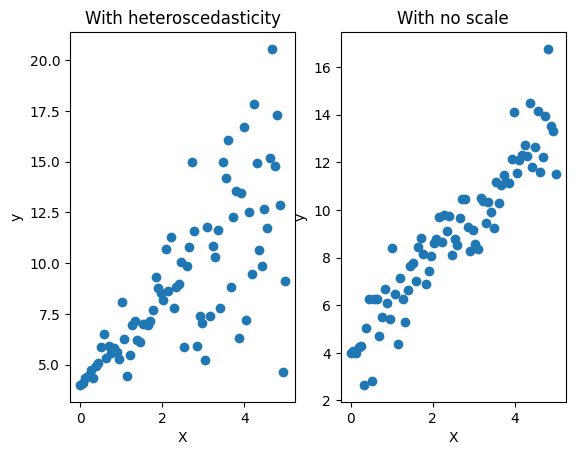

In [ ]:
plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols=  2)
axes[0].scatter(x, y1)
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")
axes[0].set_title("With heteroscedasticity")


axes[1].scatter(x, y2)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("With no scale")


Видно диспресия растет вместе с изменением x

**Последствия гетероскедастичности**

Если предположение об одинаковых дисперсиях ошибок не
выполняется, то
* стандартные ошибки коэффициентов регрессии вычисляются
по неверным формулам
* t – тесты для проверки гипотез о конкретных значениях
коэффициентов не дают правильных результатов
* F – тесты для проверки гипотез о линейных ограничениях на
коэффициенты регрессии не дают правильных результатов
* Оценки МНК коэффициентов регрессии больше не являются
BEST, теряется эффективность оценок .

# Задача 3: Борьба с Гетероскедастичностью

Рассмотрим линейную регрессионную модель

$$y_i = 10+2x_i+\varepsilon_i$$

$$x_i \sim N(40, 4)$$

$$\varepsilon_i \sim N(0,x_i^2)$$

Сгенерируем выборку размера $n=50$. Оценим модель с помощью МНК.

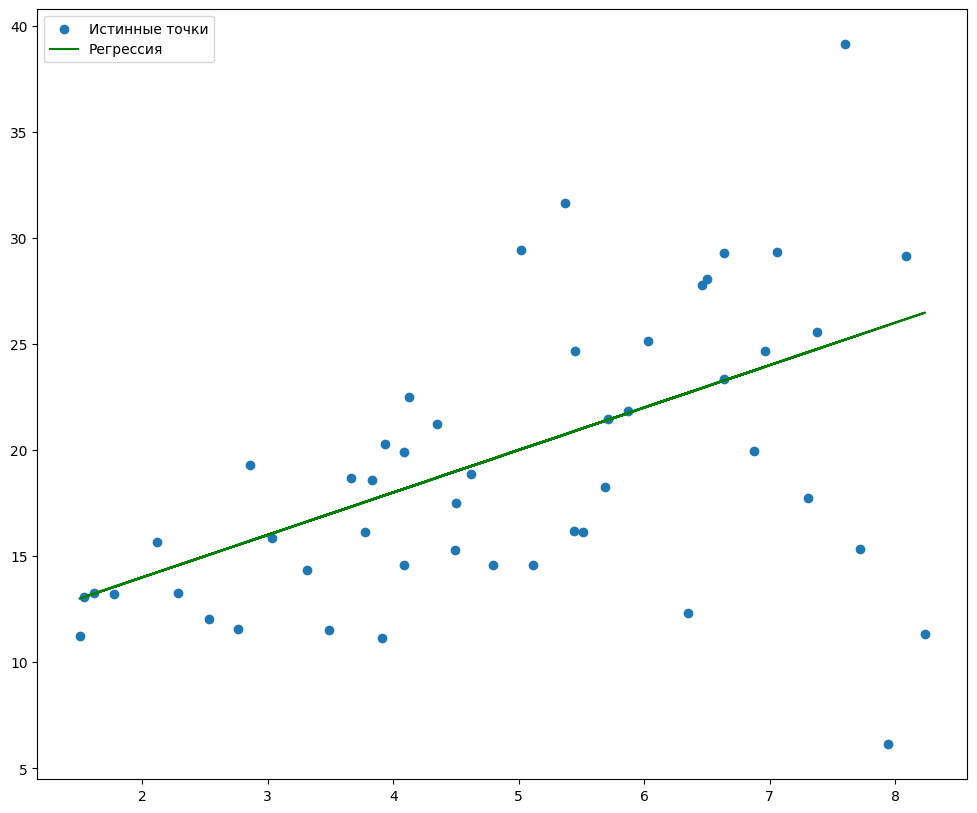

In [ ]:
x = np.random.normal(loc=5.0, scale=2.0, size=50)
eps = np.random.normal(loc=0.0, scale=x, size=50)
y = 10+2*x+eps

plt.figure(figsize=(12, 10))
plt.scatter(x, y, label='Истинные точки')
plt.plot(x, y-eps, c='g', label='Регрессия')
plt.legend()
plt.show()

In [ ]:
data = pd.DataFrame(np.vstack([x, y]).T, columns=['x', 'y'])
data.head()
model = smf.ols(data=data, formula='y ~ x').fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     14.11
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           0.000468
Time:                        15:44:03   Log-Likelihood:                -158.99
No. Observations:                  50   AIC:                             322.0
Df Residuals:                      48   BIC:                             325.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7984      2.349      4.597      0.000       6.075      15.522
x              1.6754      0.446      3.756      0.000       0.778       2.572
==============================================================================
Omnibus:                        4.486   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.549
Skew:                          -0.226   Prob(JB):                        0.103
Kurtosis:                       4.407   Cond. No.                         15.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Гипотезы о незначимости для константы и регрессора не отвергаются на любом разумном уровне значимости

### Тест Голдьфельда-Квандта

Проведём тест **Голдфельда-Квандта** на гетероскедастичность:
$$H_0: ∀ i: \sigma^2_i = \sigma^2$$
$$H_1: ∃ i, j: \sigma_i != \sigma_j$$

Для проведения теста Голдфелда – Квандта все наблюдения
упорядочиваются по Хj и делятся на 3 части. Если выборка
небольшая, то выделяют приблизительно 3/8 части всех
наблюдений для первой и третьей части и приблизительно 1/4
в середине.

Мы будем использовать тест из statmodels:

Описание алгоритма Голдфелда – Квандта:

* Упорядочиваем все наблюдения по модулю подозрительной переменной.

* Делим все наблюдения на три группы (если наблюдений достаточно много, то
приблизительно на трети). Удобно, если в первой и третьей группах количество
наблюдений одинаково.

* Наблюдениями средней группы пренебрегаем, а по первым n1 и последним n2наблюдениям оцениваем отдельные регрессии.

* Используя суммы квадратов остатков (RSS) в оцененных регрессиях,
рассчитываем тестовую статистику по формуле в первой и третий группе

* Сравниваем полученное значение F – статистики с критическим (при выбранном
уровне значимости).

* Если значение F – статистики превышает критическое, нулевая гипотеза о
гомоскедастичности отвергается.


In [ ]:
?sms.het_goldfeldquandt

In [ ]:
sms.het_goldfeldquandt(y=model.model.endog, x=model.model.exog)

(1.5561917364362055, 0.14805387869616085, 'increasing')

Гипотеза об отсутствии гетероскедастичности в модели не отвергается на любом общепринятом уровне значимости в соответствии с проведённым тестом Голдфельда-Куандта. Гетероскедастичность не выявлена

### Тест Бреуша-Пагана

1. МНК-оценка коэффициентов и остатков модели
2. Подсчёт статистики $g_i=\frac{\hat{ɛ}_i^2}{\hat{\sigma}^2}$
3. МНК-оценка регрессии типа $g_i=\gamma Z_{i}+\eta_i$, где $Z$ - признаки, выбранные для оценки гетероскедастичности (обычно $Z=X$, но Z также может быть подмножеством Х или ещё как-либо модифицированным)
4. Посчитать статистику $LM=0.5(ESS_{auxilary})\sim \chi^2(shape(Z))$, где $ESS=\sum (\hat{g_i}-\overline{g})^2$

В statsmodels вывод следующий:
1. Значение LM статистики
2. Значение p-value для LM
3. Значение F статистики (значимость регрессии на остатки, H_0 - модель не значима в целом)
4. Значение p-value для F

In [ ]:
?sms.het_breuschpagan

In [ ]:
sms.het_breuschpagan(model.resid, model.model.exog)

(12.17950661262705,
 0.0004831742272048837,
 15.45765972480103,
 0.000270458943837051)

Тест Бреуша-Пагана на гетероскедастичность не отвергает гипотезу об отсутствии гетероскедастичности в остатках на уровне значимости 0.1

WLS weighted least squares:

In [ ]:
y_weighted = y/x
const_weighted = 1/x
x_weighted = x/x
data = pd.DataFrame(np.vstack([const_weighted, y_weighted]).T, columns=['const_weighted', 'y_weighted'])
data.head()

,const_weighted,y_weighted
0,0.666458,7.476565
1,0.175890,3.209157
2,0.136872,2.428678
3,0.222463,3.396698
4,0.143624,3.545100


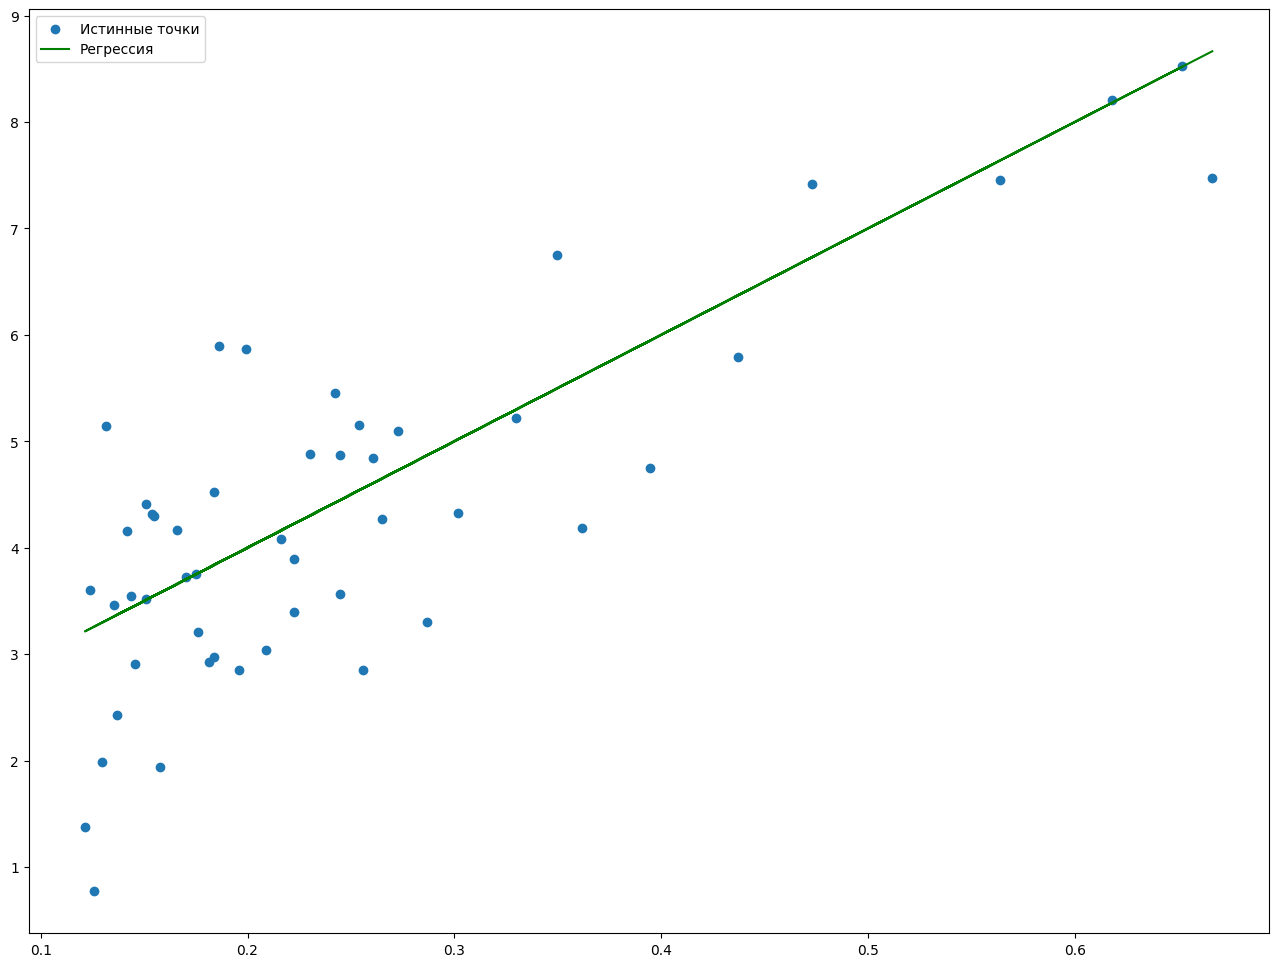

In [ ]:
plt.figure(figsize=(16, 12))
plt.scatter(const_weighted, y_weighted, label='Истинные точки')
plt.plot(const_weighted, y_weighted-eps/x, c='g', label='Регрессия')
plt.legend()
plt.show()

Визуально при взвешивании наблюдений изменился лишь угол наклона для независимой переменной, ну и в конце выборки значения стали чуть ближе к линии

In [ ]:
model2 = smf.wls(data=data, formula='y_weighted ~ const_weighted').fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             y_weighted   R-squared:                       0.636
Model:                            WLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     83.97
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           4.08e-12
Time:                        16:15:14   Log-Likelihood:                -70.519
No. Observations:                  50   AIC:                             145.0
Df Residuals:                      48   BIC:                             148.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.9461      0.297      6.551      0.000       1.349       2.543
const_weighted     9.5453      1.042      9.163      0.000       7.451      11.640
==============================================================================
Omnibus:                        0.035   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.983   Jarque-Bera (JB):                0.219
Skew:                          -0.004   Prob(JB):                        0.896
Kurtosis:                       2.676   Cond. No.                         7.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hetteroscedasticity consistent estimators

In [ ]:
model2.HC0_se

Intercept         0.286582
const_weighted    0.818420
dtype: float64

По итогам выполнения данного пункта можно сделать вывод о том, что для выборки большего размера гетероскедастичность в остатках лучше идентифицируема, при этом стандартные ошибки оценок коэффициентов, устойчивых к гетероскедастичности, почти не отличаются от исходных стандартных ошибок модели. Это означает, что при увеличении выборки корректировка на гетероскедастичность через взвешивание наблюдений обладает бОльшим смыслом. Для проверки данного тезиса выведем статистику теста Бреуша-Пагана для взвешенной модели:

In [ ]:
sms.het_breuschpagan(model2.resid, model2.model.exog)

(0.40945373228491455,
 0.5222468995402814,
 0.39632108595002813,
 0.5319805396359075)

Действительно, гетероскедастичности больше нет, модель обладает статистически эффективными оценками (хоть при этом и её качество стало околонулевым)

Оценим стандартные ошибки коэффициентов, устойчивые к гетероскедастичности, при помощи какой-нибудь из схем HC. Поменялось ли что-нибудь?


Воспользуемся способом, изученным на семинаре: исправим только доверительные инетрвалы для параметров модели, оцениваемой при помощи МНК,так, чтобы они были устойчивы к гетероскедастичности. Тогда

$$
\hat{\mathrm{Var}}(\hat{\beta}_{OLS})_{HC} = (X'X)^{-1}X'\hat{\mathrm{Var}}(u)_{HC}X(X'X)^{-1}.
$$

В качестве $\hat{\mathrm{Var}}(u)_{HC_0}$ возьмём диагональную матрицу от квадратов оценённых остатков исходной модели - $\mathrm{diag}(\hat{u}^2_1, \ldots, \hat{u}^2_n)$

In [ ]:
model.cov_params()

,Intercept,x
Intercept,22888.551614,-569.414901
x,-569.414901,14.188806


In [ ]:
var_u = np.diag(np.power(model.resid, 2))
var_u.shape

(50, 50)

In [ ]:
exog = model.model.exog
Var_HC = np.linalg.inv(exog.T @ exog) @ exog.T @ var_u @ exog @ np.linalg.inv(exog.T @ exog)
df_var_hc = pd.DataFrame(Var_HC, columns = model.model.exog_names, index = model.model.exog_names)
df_var_hc

,Intercept,x
Intercept,20098.536229,-503.92384
x,-503.923840,12.65641


In [ ]:
model.cov_params()

,Intercept,x
Intercept,22888.551614,-569.414901
x,-569.414901,14.188806


Видим, что стандартная ошибка коэффициента для коснтанты уменьшилась примерно на 0.05 по сравнению с исходной моделью, тогда как все остальные коэффициенты незначительно увеличились, покажем изменения наглядно:

In [ ]:
df_var_hc / model.cov_params()

,Intercept,x
Intercept,0.878104,0.884985
x,0.884985,0.892000


##Выводы

In [ ]:
model.pvalues.astype(np.float16)

Intercept    0.156616
x            0.421387
dtype: float16

In [ ]:
model2.pvalues.astype(np.float16)

Intercept         0.414307
const_weighted    0.148193
dtype: float16

Видим, что для исходного и взвешенного Х в МНК и ДВМНК моделях гипотеза о незначимости коэффициента при независимой переменной не отвергается на любом разумном уровне значимости. Это говорит о том, что Х  не оказывает существенного влияния на У, которое получилось идентифицировать в рамках моделирования регрессии. И на графиках выше для выборки размером 10000 наблюдений это очевидно, поскольку угол наклона линии регрессии находится на уровне нуля.

В свою очередь, для исходной и взвешенной константы в МНК и ДВМНК гипотеза о незначимости коэффициента при константе не отвергается на уровне значимости как минимум 15%. Это означает, что точка пересечения линии регрессии с осью ОУ может лежать как выше оси ОХ, так и ниже её, то есть усреднённый результат зависимой переменной варьируется достаточно сильно, чтобы уверенно распознать значимое отличие от 0. Ну что ж, бывает, при этом с учётом столь большого значения ошибок модели это достаточно очевидный результат

# Задача 4: проверка гауссовости

* $H_0: ɛ \sim N(0, \sigma^2)$
* $H_1: иначе$

Text(0.5, 1.0, 'Exponential residuals')

<Figure size 1000x1000 with 0 Axes>

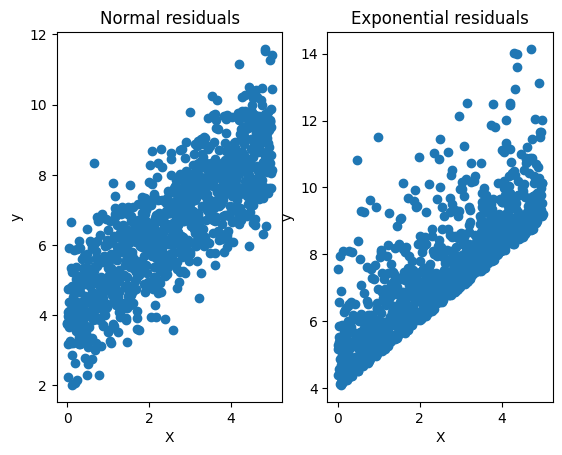

In [ ]:
x = np.linspace(0,5,1000)

y1 = 4 + x +np.random.normal(size=x.shape)
y2 =  4 + x +np.random.exponential(size=x.shape)

plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols=  2)
axes[0].scatter(x, y1)
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")
axes[0].set_title("Normal residuals")


axes[1].scatter(x, y2)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("Exponential residuals")

In [ ]:
data = pd.DataFrame(np.vstack([x, y2]).T, columns=['x', 'y'])
data.head()
model = smf.ols(data=data, formula='y ~ x').fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1824.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):          1.67e-227
Time:                        16:20:26   Log-Likelihood:                -1466.3
No. Observations:                1000   AIC:                             2937.
Df Residuals:                     998   BIC:                             2946.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0806      0.066     76.593      0.000       4.950       5.211
x              0.9812      0.023     42.710      0.000       0.936       1.026
==============================================================================
Omnibus:                      384.220   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.700
Skew:                           1.891   Prob(JB):                    7.33e-287
Kurtosis:                       7.162   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

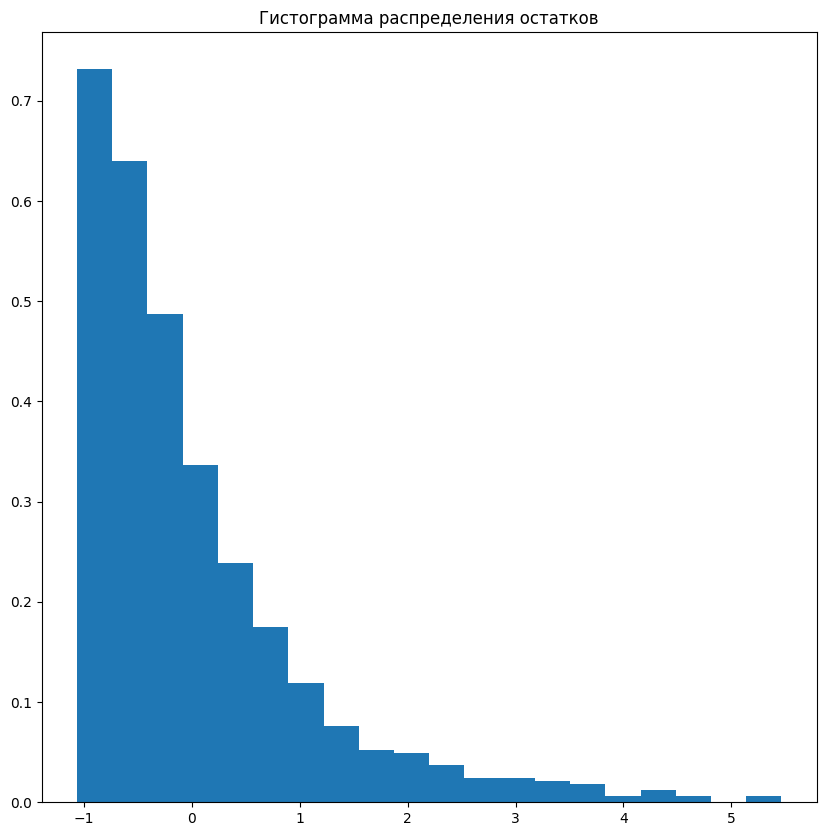

In [ ]:
res = model.resid
counts, bins = np.histogram(res, bins=20, density=True)

plt.figure(figsize = (10,10))
plt.title('Гистограмма распределения остатков')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

## Критерий Колмогорова

In [ ]:
smd.kstest_normal(res)

(0.15478753080382168, 0.0009999999999998899)

* Значение статистики Колмогорва-Смирнова
* p-value

Видим, что гипотеза о нормальности остатков отвергается на любом разумном уровне значимости

## Критерий Андерсона-Дарлинга

In [ ]:
smd.normal_ad(res)

(51.9122094601903, 0.0)

* Значение статистики Андерсона-Дарлинга
* p-value гипотезы о нормальности остатков

Отвергается

## Критерии Жарке-Бера и Omnibus

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1824.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):          1.67e-227
Time:                        16:20:37   Log-Likelihood:                -1466.3
No. Observations:                1000   AIC:                             2937.
Df Residuals:                     998   BIC:                             2946.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0806      0.066     76.593      0.000       4.950       5.211
x              0.9812      0.023     42.710      0.000       0.936       1.026
==============================================================================
Omnibus:                      384.220   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.700
Skew:                           1.891   Prob(JB):                    7.33e-287
Kurtosis:                       7.162   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* В последних 4 строчках видим статистику и p-value для тестова Jarque-Bera & Omnibus, в которых видно, что гипотеза о нормальности распределения остатков также отвергается

## Проверка мощности тестов

In [ ]:
list(range(25, 100, 25))+list(range(100, 1000, 200))

[25, 50, 75, 100, 300, 500, 700, 900]

In [ ]:
def check_power(max_sample_size=1000,
                num_samples = 1000,
                alpha = 0.05,
                errors_type='exponential'):
  portion_of_accepted_ks = dict()
  portion_of_accepted_ad = dict()
  portion_of_accepted_jb = dict()
  portion_of_accepted_om = dict()
  # итерируемся по размеру выборки
  if max_sample_size>100:
    sample_sizes = list(range(20, 100, 20))+list(range(100, max_sample_size, 200))
  else:
    sample_size =  list(range(20, max_sample_size, 10))
  for n in range(25, max_sample_size, 25):
    portion_of_accepted_ks[n] = 0
    portion_of_accepted_ad[n] = 0
    portion_of_accepted_jb[n] = 0
    portion_of_accepted_om[n] = 0

    # итерируемся по разным выборкам
    for i in range(num_samples):
      x = np.linspace(0,5,n)
      np.random.seed(n*i)

      # генерим y
      if errors_type == 'exponential':
        y =  4 + x +np.random.exponential(size=x.shape)
      elif errors_type == 'normal':
        y =  4 + x +np.random.normal(size=x.shape)

      data = pd.DataFrame(np.vstack([x, y]).T, columns=['x', 'y'])
      model = smf.ols(data=data, formula='y ~ x').fit()

      # выбираем тест
      p_values = [smd.kstest_normal(model.resid)[1], smd.normal_ad(model.resid)[1], smst.jarque_bera(model.resid)[1], smst.omni_normtest(model.resid)[1]]

      # обновляем значение доли принятых тестов
      if p_values[0]>alpha:
        portion_of_accepted_ks[n] += 1/num_samples
      if p_values[1]>alpha:
        portion_of_accepted_ad[n] += 1/num_samples
      if p_values[2]>alpha:
        portion_of_accepted_jb[n] += 1/num_samples
      if p_values[3]>alpha:
        portion_of_accepted_om[n] += 1/num_samples

  return portion_of_accepted_ks, portion_of_accepted_ad, portion_of_accepted_jb, portion_of_accepted_om

In [ ]:
import warnings
warnings.filterwarnings("ignore")

ks_exp, ad_exp, jb_exp, om_exp = check_power()
ks_norm, ad_norm, jb_norm, om_norm = check_power(errors_type='normal')

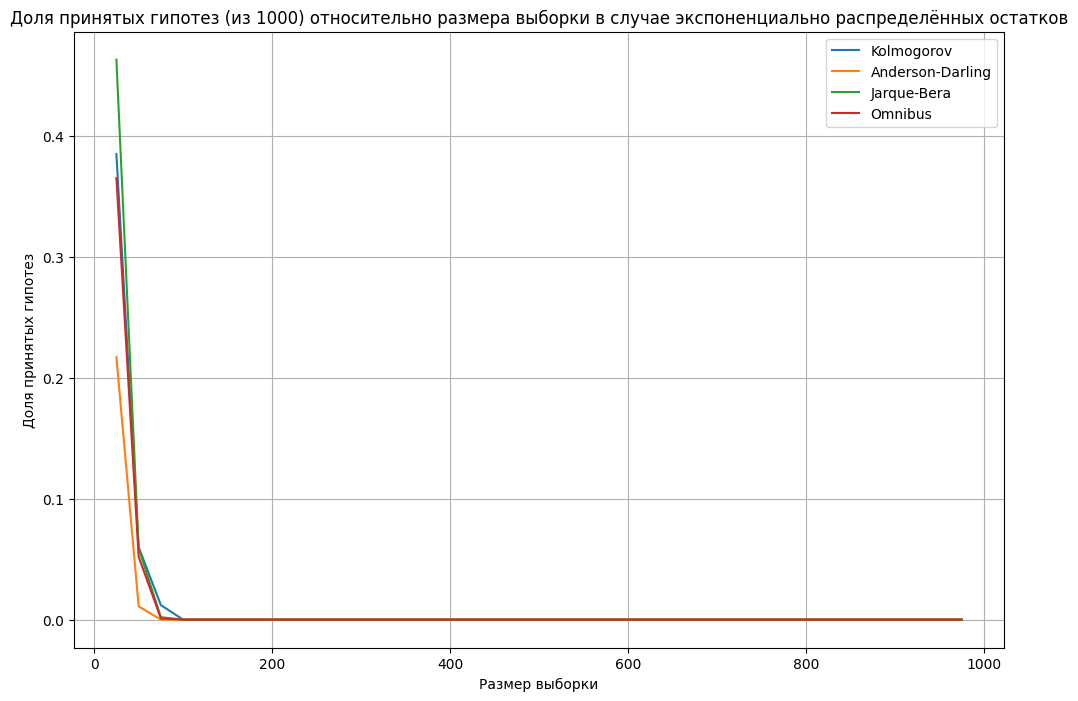

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(ks_exp.keys(), ks_exp.values(), label='Kolmogorov')
plt.plot(ad_exp.keys(), ad_exp.values(), label='Anderson-Darling')
plt.plot(jb_exp.keys(), jb_exp.values(), label='Jarque-Bera')
plt.plot(om_exp.keys(), om_exp.values(), label='Omnibus')

plt.legend()
plt.title('Доля принятых гипотез (из 1000) относительно размера выборки в случае экспоненциально распределённых остатков')
plt.grid()
plt.xlabel('Размер выборки')
plt.ylabel('Доля принятых гипотез')
plt.show()

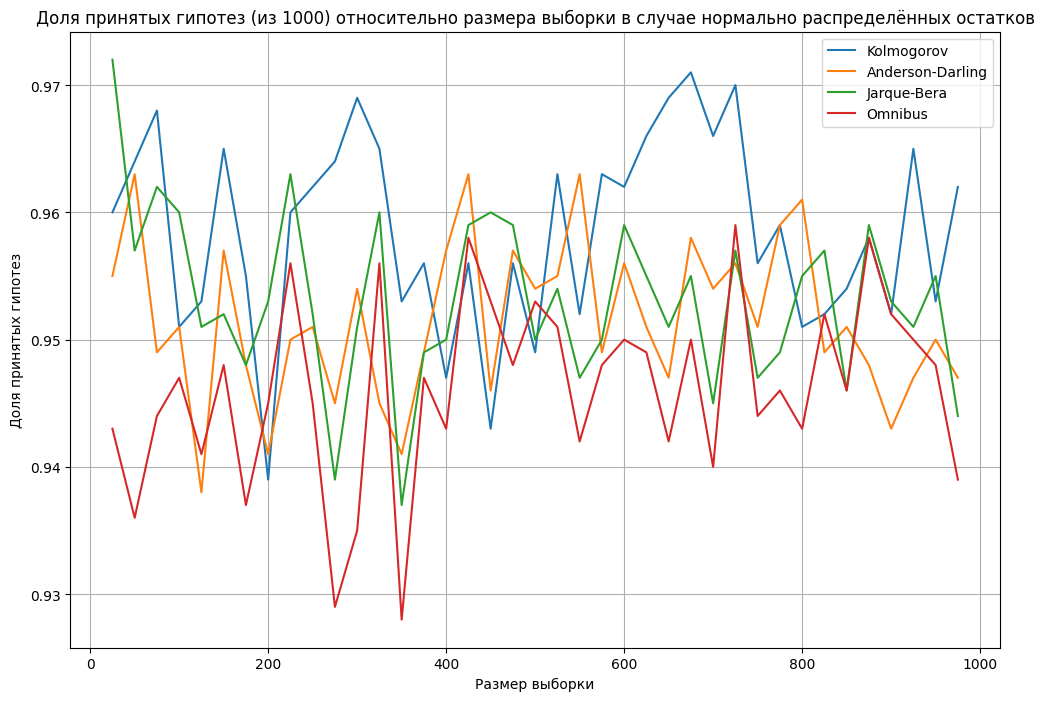

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(ks_norm.keys(), ks_norm.values(), label='Kolmogorov')
plt.plot(ad_norm.keys(), ad_norm.values(), label='Anderson-Darling')
plt.plot(jb_norm.keys(), jb_norm.values(), label='Jarque-Bera')
plt.plot(om_norm.keys(), om_norm.values(), label='Omnibus')

plt.legend()
plt.title('Доля принятых гипотез (из 1000) относительно размера выборки в случае нормально распределённых остатков')
plt.grid()
plt.xlabel('Размер выборки')
plt.ylabel('Доля принятых гипотез')
plt.show()

## Как можно побороть негауссовость остатков?

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(x)
model = sm.GLM(exog=X, endog=y2, family=sm.families.Gamma()).fit()

model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                        0.022588
Method:                          IRLS   Log-Likelihood:                -1457.6
Date:                Fri, 20 Oct 2023   Deviance:                       19.891
Time:                        16:30:03   Pearson chi2:                     22.5
No. Iterations:                     6   Pseudo R-squ. (CS):             0.7926
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1810      0.001    122.480      0.000       0.178       0.184
x1            -0.0174      0.000    -39.452      0.000      -0.018      -0.017
==============================================================================
"""

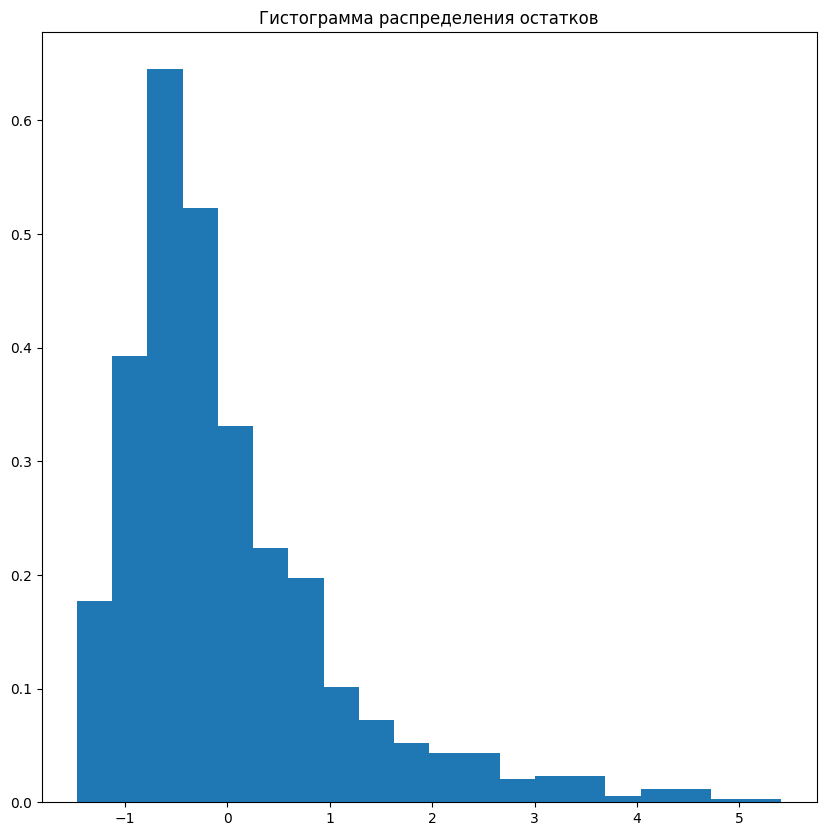

In [ ]:
res = model.resid_response
counts, bins = np.histogram(res, bins=20, density=True)

plt.figure(figsize = (10,10))
plt.title('Гистограмма распределения остатков')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

# Задача 5 FWL: (Frisch–Waugh–Lovell theorem) (опционально)
https://en.wikipedia.org/wiki/Frisch%E2%80%93Waugh%E2%80%93Lovell_theorem



Сравним два подхода к линейной регрессии:
Модель зависимаемая от двух переменных u и x.
1.    $y = \beta_0+\beta_u u+\beta_x x+\epsilon$
Посчитаем $\hat{se}(\beta_u)$
2. После получения оценки на парметры $\beta_u , \beta_x$ с  помощью МНК,
посчитаем остаток как $r_x = y - \beta_x x$ и теперь оценим модель линейной регрессии:

  $r_x = \alpha_0+\alpha_u u +\varepsilon$



*   Отличаются ли оценки параметров $\beta_u$  и $\alpha_u$?

*  Чем отличаются оценки стандарных отклонения этих параметров: $\hat{se}(\beta_u)$ и $\hat{se}(\alpha_u)$?

Appendix

Решение про нахождение оценок для $\beta_u$  и $\alpha_u$


Пусть
$ X = \begin{bmatrix}
1 & u_1 & x_1\\
1 & u_2 & x_2 \\
⋯ &⋯  & ⋯ \\
1 & u_n & x_n
\end{bmatrix}$

Пусть $V= \begin{bmatrix}
1 & u_1 & x_1\\
1 & u_2 & x_2 \\
⋯ &⋯  & ⋯ \\
1 & u_n & x_n
\end{bmatrix} \begin{bmatrix}
1 & 0 \\
0 & 1 \\
0 & 0
\end{bmatrix} = X[:,: 2]$. берем первые два столбца матрицы X

Тогда

$\beta = (X^{T}X)^{-1}X^{T}y$

$$
r=y-\hat{\beta}_x x=y-X\left[\begin{array}{c}
0 \\
0 \\
\hat{\beta}_x
\end{array}\right] .
$$
Предположим коэффициентов, тогда:
$$
\begin{array}{l}
\beta_u=\alpha_u \Longleftrightarrow\left(\left(X^T X\right)^{-1} X^T y\right)[1]=\left(\left(V^T V\right)^{-1} V^T r\right)[1] \\
\Longleftrightarrow\left(\left(X^T X\right)^{-1} X^T y\right)^{T}\left[\begin{array}{c}
0 \\
1 \\
0
\end{array}\right]=\left(\left(X^T X\right)[: 2,: 2]^{-1} X[:,: 2]^T\left(y-X\left[\begin{array}{c}
0 \\
0 \\
\hat{\beta}_x
\end{array}\right]\right)\right)^{T}\left[\begin{array}{c}
0 \\
1
\end{array}\right],
\end{array}
$$
что следует из
$$
\left(\left(X^T X\right)^{-1} X^T y\right)[: 2]=\left(X^T X\right)[: 2,: 2]^{-1} X[:,: 2]^T\left(y-X\left[\begin{array}{c}
0 \\
0 \\
\left(\left(X^T X\right)^{-1} X^T y\right)[2]
\end{array}\right]\right),
$$
что эквивалентно
$$
\left(\left(X^T X\right)^{-1} X^T y\right)[: 2]=\left(X^T X\right)[: 2,: 2]^{-1}\left(X^T\left(y-X\left[\begin{array}{c}
0 \\
0 \\
\left(\left(X^T X\right)^{-1} X^T y\right)[2]
\end{array}\right]\right)\right)[: 2],
$$
что эквивалентно
$$
\left(\left(X^T X\right)^{-1} X^T y\right)[: 2]=\left(X^T X\right)[: 2,: 2]^{-1}\left(X^T y-X^T X\left[\begin{array}{c}
0 \\
0 \\
\left(\left(X^T X\right)^{-1} X^T y\right)[2]
\end{array}\right]\right)[: 2],
$$
что следует из (for $\Sigma=X^T X$ and $b=X^T y$ )
$$
\left(\Sigma^{-1} b\right)[: 2]=\Sigma[: 2,: 2]^{-1}\left(b-\Sigma\left[\begin{array}{c}
0 \\
0 \\
\left(\Sigma^{-1} b\right)[2]
\end{array}\right]\right)[: 2]
$$
что следует из (for $c=\Sigma^{-1} b$ )
$$
c[: 2]=\Sigma[: 2,: 2]^{-1}\left(\Sigma c-\Sigma\left[\begin{array}{c}
0 \\
0 \\
c[2]
\end{array}\right]\right)[: 2]
$$
что следует из
$$
\Sigma[: 2,: 2] c[: 2]=\left(\Sigma c-\Sigma\left[\begin{array}{c}
0 \\
0 \\
c[2]
\end{array}\right]\right)[: 2],
$$
что видно из
$$
\Sigma[:,: 2] c[: 2]=\Sigma c-\Sigma\left[\begin{array}{c}
0 \\
0 \\
c
\end{array}\right]
$$
Ч. Т. Д.

Найдем оценки на дисперсию оценок:

Решение задачи FWL:
Пусть
$ X = \begin{bmatrix}
1 & u_1 & x_1\\
1 & u_2 & x_2 \\
⋯ &⋯  & ⋯ \\
1 & u_n & x_n
\end{bmatrix}$

Пусть $V=X[:,: 2]$. берем первые два столбца матрицы X
$$
\begin{array}{c}
\hat{\operatorname{Var}}_{\text {class }}(\hat{\beta})=\frac{\sum\left(y_i-\hat{y}_i\right)^2}{n-3}\left(X^T X\right)^{-1}=\frac{\left\|y-X\left(X^T X\right)^{-1} X^T y\right\|_F^2}{n-3}\left(X^T X\right)^{-1} \\
\hat{\operatorname{Var}}_{\text {class }}(\hat{\gamma})=\frac{\sum\left(r_i-\hat{r}_i\right)^2}{n-2}\left(V^T V\right)^{-1}=\frac{\left\|r-Y\left(V^T V\right)^{-1} V^T r\right\|_F^2}{n-2}\left(V^T V\right)^{-1} \\
\frac{\operatorname{se}_{\text {class }}\left(\hat{\beta}_w\right)}{\operatorname{se}_{\text {class }}\left(\hat{\gamma}_w\right)}=\frac{\sqrt{\operatorname{Var}_{\text {class }}(\hat{\beta})[1,1]}}{\sqrt{\operatorname{Var}_{\text {class }}(\hat{\gamma})[1,1]}}=\sqrt{\frac{n-2}{n-3} \cdot \frac{\left\|\left(I-X\left(X^T X\right)^{-1} X^T\right) y\right\|_F^2\left(X^T X\right)^{-1}[1,1]}{\left\|\left(I-V\left(V^T V\right)^{-1} V^T\right) r\right\|_F^2\left(V^T V\right)^{-1}[1,1]}}
\end{array}
$$
Ответ:
$$
\sqrt{\frac{n-2}{n-3} \cdot \frac{\left(\left\|\left(I-X\left(X^T X\right)^{-1} X^T\right) y\right\|_F^2\left(X^T X\right)^{-1}\right)_{2,2}}{\left(\left\|\left(I-V\left(V^T V\right)^{-1} V^T\right) r\right\|_F^2\left(V^T V\right)^{-1}\right)_{2,2}}}
$$